In [1]:
get_ipython().magic('matplotlib inline')

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import pylab as pl
import xgboost as xgb

from functools import reduce

In [3]:
def itercols(dataframe):
    for col in dataframe.columns:
        yield (col, dataframe[col])

In [4]:
from pandas import read_csv, DataFrame, Series
data = read_csv('~/kaggle/santander/train.csv')

In [5]:
cdata = data.drop(['ID', 'TARGET'], axis=1)
cdata[[kv[0] for kv in filter(lambda kv: kv[1], cdata.mean().isnull().items())]].count()

Series([], dtype: int64)

In [6]:
#log scaling features with higher than criterion_to_log difference between min and max
criterion_to_log = 1e2
cols_to_log = [kv[0] for kv in filter(lambda nc: np.abs(nc[1].min() - nc[1].max()) > criterion_to_log, itercols(cdata))]
offsets = {}
for col in cols_to_log:
    offset = np.abs(cdata[col]).max() + np.exp(1)
    offsets[col] = offset
    cdata[col] = np.log(cdata[col] + offset)# - np.log(offset)

In [7]:
#feature scaling
#from sklearn import preprocessing

#for col in cdata.columns:
#    cdata[col] = preprocessing.StandardScaler().fit_transform(np.array(cdata[col]).astype(np.float64).reshape(-1,1))

means = {}
deviations = {}

for col in cdata.columns:
    ser = cdata[col]
    
    mean = ser.mean()
    if np.abs(mean) < 1e-10:
        continue
    
    dev = ser.std(ddof=1)
    if np.abs(dev) < 1e-10:
        continue
    
    #print("mean = ", mean, " dev = ", dev, "\n")
    
    means[col] = mean
    deviations[col] = dev
    
    cdata[col] = (ser - mean) / dev

In [8]:
#cdata.isnull().apply(lambda col: reduce(lambda x,y: x or y, col))

In [9]:
#feature count reduction
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = int(len(cdata.columns) / 10))
svd_tr = svd.fit(cdata)

In [10]:
cdata = DataFrame(svd_tr.transform(cdata))

In [11]:
Y = data['TARGET']
X = cdata
kcv = 5
cvd = {}

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
model_rfc = RandomForestClassifier(n_estimators = 100, n_jobs=-1)
model_xgb = xgb.XGBClassifier(objective = "binary:logistic", reg_lambda = 0, reg_alpha = 1, max_depth=15, n_estimators=100, learning_rate=0.3, nthread=-1)

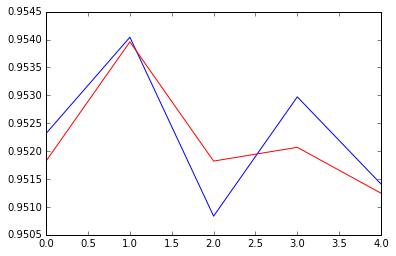

In [14]:
scores = cross_validation.cross_val_score(model_rfc, X_train, y_train, cv = kcv)
cvd['RandomForestClassifier'] = scores

scores = cross_validation.cross_val_score(model_rfc, X_train, y_train, cv = kcv)
cvd['XGBClassifier'] = scores

plt.plot(range(len(scores)), cvd['RandomForestClassifier'], 'b', range(len(scores)), cvd['XGBClassifier'], 'r')
plt.show()

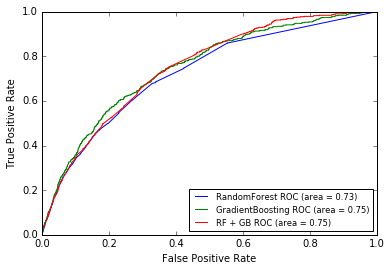

In [15]:
pl.clf()

rf_probas = model_rfc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, rf_probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForest',roc_auc))

gb_probas = model_xgb.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, gb_probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('GradientBoosting',roc_auc))

rf_gb_probas = np.maximum(rf_probas, gb_probas)
fpr, tpr, thresholds = roc_curve(y_test, rf_gb_probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RF + GB',roc_auc))

pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

In [16]:
testdata = read_csv('~/kaggle/santander/test.csv')
ctestdata = testdata.drop(['ID'], axis=1)

In [17]:
#log scaling test samle
for col in cols_to_log:
    offset = offsets[col]
    ctestdata[col] = np.log(ctestdata[col] + offset)# - np.log(offset)

In [18]:
#standardizing
for col in means:
    mean, dev = means[col], deviations[col]
    ctestdata[col] = (ctestdata[col] - mean) / dev

In [19]:
#feature count reduction
ctestdata = DataFrame(svd_tr.transform(ctestdata))

In [20]:
result = DataFrame(testdata['ID'])
pred_xgb = model_xgb.fit(X, Y).predict(ctestdata)
result.insert(1,'TARGET', pred_xgb)
result.to_csv('~/ml/kaggle_santander_happy_customers/res_xgb.csv', index=False)

result = DataFrame(testdata['ID'])
pred_rfc = model_rfc.fit(X, Y).predict(ctestdata)
result.insert(1,'TARGET', pred_rfc)
result.to_csv('~/ml/kaggle_santander_happy_customers/res_rf.csv', index=False)

result = DataFrame(testdata['ID'])
result.insert(1,'TARGET', np.maximum(pred_xgb, pred_rfc))
result.to_csv('~/ml/kaggle_santander_happy_customers/res_xgb_rf.csv', index=False)

In [21]:
print("RF predicts ", len(list(filter(lambda c: c == 1, pred_rfc))), " of ", len(result), " as true")
print("XGB predicts ", len(list(filter(lambda c: c == 1, pred_xgb))), " of ", len(result), " as true")
print("RF+GB predicts ", len(list(filter(lambda c: c == 1, np.maximum(pred_xgb, pred_rfc)))), " of ", len(result), " as true")

RF predicts  999  of  75818  as true
XGB predicts  701  of  75818  as true
RF+GB predicts  1184  of  75818  as true
